In [16]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
from functools import partial
import pandas

# Loading in the graph
The JSON files have the graph already built. Each node represents a precinct and each edge represents a border between two precincts, only drawn between neighbors. Nodes also contain information about a precinct, such as the total population and demographic information.

In [17]:
graph = Graph.from_json("./data/pa/PA_VTDs.json")

In [18]:
# Get info about the first node of the graph
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 0.06312599142331599,
 'area': 0.004278359631999892,
 'STATEFP10': '42',
 'COUNTYFP10': '085',
 'VTDST10': '960',
 'GEOID10': '42085960',
 'VTDI10': 'A',
 'NAME10': 'SHENANGO TWP VTD WEST',
 'NAMELSAD10': 'SHENANGO TWP VTD WEST',
 'LSAD10': '00',
 'MTFCC10': 'G5240',
 'FUNCSTAT10': 'N',
 'ALAND10': 39740056,
 'AWATER10': 141805,
 'INTPTLAT10': '+41.1564874',
 'INTPTLON10': '-080.4865792',
 'TOTPOP': 1915,
 'NH_WHITE': 1839,
 'NH_BLACK': 35,
 'NH_AMIN': 1,
 'NH_ASIAN': 8,
 'NH_NHPI': 0,
 'NH_OTHER': 3,
 'NH_2MORE': 19,
 'HISP': 10,
 'H_WHITE': 3,
 'H_BLACK': 0,
 'H_AMIN': 1,
 'H_ASIAN': 0,
 'H_NHPI': 0,
 'H_OTHER': 4,
 'H_2MORE': 2,
 'VAP': 1553,
 'HVAP': 7,
 'WVAP': 1494,
 'BVAP': 30,
 'AMINVAP': 1,
 'ASIANVAP': 6,
 'NHPIVAP': 0,
 'OTHERVAP': 2,
 '2MOREVAP': 13,
 'ATG12D': 514.0001036045286,
 'ATG12R': 388.0000782073095,
 'F2014GOVD': 290.0000584539169,
 'F2014GOVR': 242.00004877878584,
 'GOV10D': 289.00005825235166,
 'GOV10R': 349.000070346265

# Setting up the initial partition
The initial partition is an object representing the start state of our markov chain, which we set to the 2011 map. We also need to add updaters to the partition, which are functions that update the partition as the markov chain runs with what we're looking for: the total population and number of white people in the district. We also add constraints to ensure compactness and equal population.

In [19]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"), "whitepop": updaters.Tally("NH_WHITE", alias="whitepop")}

In [20]:
initial_partition = GeographicPartition(graph, assignment="CD_2011", updaters=my_updaters)

In [21]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [22]:
# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

In [23]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

# Markov chain
Next, we set up our markov chain. First, we set it up with all the necessary parameters: the constraints, initial state, and total number of steps. Then, we run the markov chain and save the results to variables.

In [24]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000
)

In [25]:
compactness = []
whiteprop = []

In [26]:
for partition in chain.with_progress_bar():
    compactness.append(sorted(polsby_popper(partition).values()))
    whiteprop.append(sorted([whitepop / partition["population"][i] for i, whitepop in partition["whitepop"].items()]))

100%|██████████| 10000/10000 [41:12<00:00,  4.04it/s] 


# Analysis
Finally, we analyze the data. We look at the boxplots of the target paremeters and compare the 2011 plan's values to the relevant distributions. Each boxplot represents the least white population proportion, second least, and so on, or the least compact to most compact in the case of the compactness graph. In a good, representative map, every value should fall within the 25th and 75th percentile of the naive distribution.

In [27]:
compactness_df = pandas.DataFrame(compactness)

In [28]:
compactness_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.039749,0.074284,0.076012,0.078486,0.078655,0.098114,0.111457,0.119048,0.130381,0.132231,0.134152,0.139674,0.169031,0.221513,0.250086,0.354915,0.364298,0.393607
1,0.070608,0.074284,0.076012,0.078486,0.098114,0.111457,0.119048,0.130381,0.132231,0.134152,0.139674,0.149198,0.169031,0.221513,0.250086,0.354915,0.364298,0.393607
2,0.070608,0.074284,0.076012,0.078486,0.098114,0.111457,0.119048,0.130381,0.132231,0.134152,0.139674,0.149198,0.169031,0.229337,0.273366,0.354915,0.364298,0.393607
3,0.070608,0.074284,0.076012,0.078486,0.111457,0.119048,0.132231,0.134152,0.139674,0.142516,0.149198,0.169031,0.196231,0.229337,0.273366,0.354915,0.364298,0.393607
4,0.070608,0.074284,0.076012,0.078486,0.111457,0.119048,0.132231,0.134152,0.139674,0.142516,0.149198,0.169031,0.196231,0.254734,0.256170,0.354915,0.364298,0.393607


In [29]:
whiteprop_df = pandas.DataFrame(whiteprop)

In [30]:
whiteprop_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.28576,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.84823,0.858903,0.867371,0.870007,0.881711,0.912313,0.91418,0.930897,0.936399,0.936662,0.937664
1,0.28576,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.84823,0.854229,0.867371,0.874437,0.881711,0.912313,0.91418,0.930897,0.936399,0.936662,0.937664
2,0.28576,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.84823,0.854229,0.867371,0.874437,0.881711,0.908391,0.91418,0.930897,0.936399,0.936662,0.941393
3,0.28576,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.84823,0.854229,0.867371,0.874437,0.881711,0.908391,0.91418,0.930083,0.936662,0.937282,0.941393
4,0.28576,0.417547,0.622189,0.715684,0.747023,0.792727,0.829054,0.84823,0.854229,0.867371,0.874437,0.881711,0.910075,0.91418,0.930083,0.936662,0.937282,0.940349


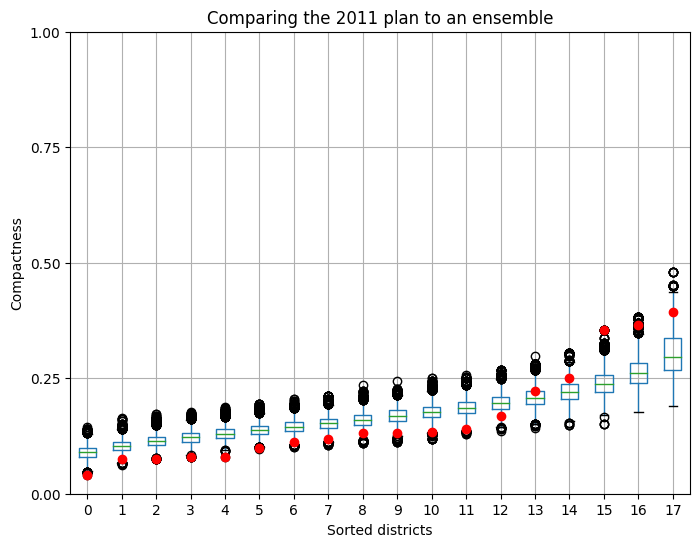

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))


# Draw boxplot
compactness_df.boxplot(ax=ax, positions=range(len(compactness_df.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(compactness_df.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Compactness")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.savefig("images/pa-compactness.png")

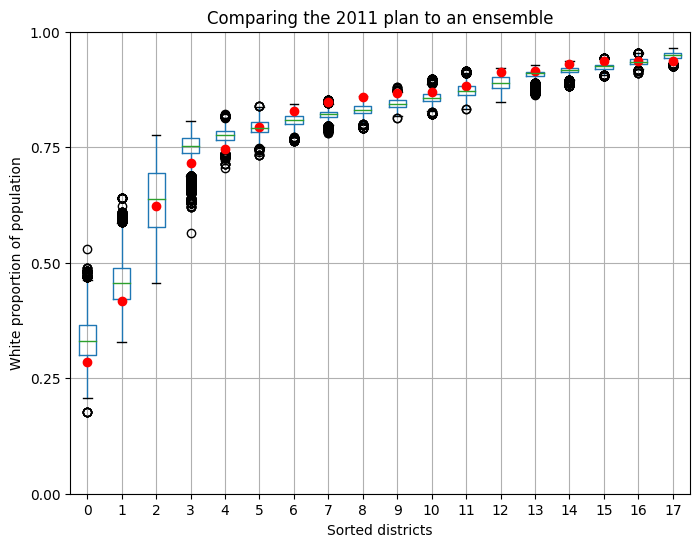

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))


# Draw boxplot
whiteprop_df.boxplot(ax=ax, positions=range(len(whiteprop_df.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(whiteprop_df.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("White proportion of population")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.savefig("images/pa-race.png")